# Leaf Morphology Analysis
**Author**: Emma Tung Corcoran </br>
**Date Last Modified**: August 30, 2021 </br>
**Description**: Leaf morphology traits can be quantified using the Aradeepopsis tool https://github.com/Gregor-Mendel-Institute/aradeepopsis to generate a csv file with different traits. This file can subsequently be analyzed using dimensionality reduction and clustering techniques with the following workflow.

In [1]:
#Load required dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import community as community_louvain
import networkx as nx
import phate
import scprep
import seaborn as sns

In [2]:
#Set path to save plot
save_path = "/Users/emmacorcoran/Documents/Jupyter Code/Leaf_morphology_08112021"

## Load and Clean Data

In [3]:
#Load data matrices
#Profile values at each gene
base_path = "/Users/emmacorcoran/Documents/Jupyter Code/Leaf_morphology_08112021"
filename = "aradeepopsis_traits.csv"
path_to_file = os.path.join(base_path, filename)
df = pd.read_csv(path_to_file)

#Metadata
base_path = "/Users/emmacorcoran/Documents/Jupyter Code/Leaf_morphology_08112021"
filename = "Leaf_Morphology_metadata.csv"
path_to_file = os.path.join(base_path, filename)
metadata = pd.read_csv(path_to_file)

In [4]:
df.head()

,file,format,plant_region_red_channel,plant_region_green_channel,plant_region_blue_channel,plant_region_chroma_ratio,plant_region_chroma_difference,plant_region_chroma_base,plant_region_green_strength,plant_region_blue_green_ratio,...,class_norm_solidity,class_norm_aspect_ratio,class_norm_red_channel,class_norm_green_channel,class_norm_blue_channel,class_norm_chroma_ratio,class_norm_chroma_difference,class_norm_chroma_base,class_norm_green_strength,class_norm_blue_green_ratio
0,4-9 12,jpg,146.661231,183.947811,99.246248,1.496073,-60.994072,1.336833,0.427930,0.539535,...,0.286757,1.316661,146.661231,183.947811,99.246248,1.496073,-60.994072,1.336833,0.427930,0.539535
1,7-2 7,jpg,98.345382,125.994489,42.533189,1.788696,-55.555203,1.118133,0.472114,0.337580,...,0.462380,1.056867,98.345382,125.994489,42.533189,1.788696,-55.555203,1.118133,0.472114,0.337580
2,9-7 8,jpg,107.553110,136.261422,52.452003,1.703213,-56.258866,1.174251,0.459928,0.384937,...,0.462004,1.140478,107.553110,136.261422,52.452003,1.703213,-56.258866,1.174251,0.459928,0.384937
3,29-3 3,jpg,159.189513,175.793912,84.556660,1.442434,-53.920825,1.386545,0.419016,0.480999,...,0.302884,1.549992,159.189513,175.793912,84.556660,1.442434,-53.920825,1.386545,0.419016,0.480999
4,29-5 5,jpg,146.020015,177.580117,80.985596,1.564544,-64.077311,1.278328,0.438918,0.456051,...,0.306651,1.329443,146.020015,177.580117,80.985596,1.564544,-64.077311,1.278328,0.438918,0.456051


In [5]:
metadata.head()

,genotype,line
0,Col,Col
1,H4_sept,H4
2,rH4-1,68-21C
3,rH4-2,68-18D
4,H4R3K-1,2-1


In [6]:
# Drop format column
df = df.drop(['format'],axis=1)

In [7]:
# Add metadata column with sample genotype to each sample row
df.insert(1, 'genotype', "NA")

for i in range(df.shape[0]):
    filename = df.iloc[i,0].split()[0]
    idx = metadata.index[metadata['line']==filename]
    genotype = metadata.iloc[idx,0].item()
    df.iloc[i, 1] = genotype

In [8]:
df.head()

,file,genotype,plant_region_red_channel,plant_region_green_channel,plant_region_blue_channel,plant_region_chroma_ratio,plant_region_chroma_difference,plant_region_chroma_base,plant_region_green_strength,plant_region_blue_green_ratio,...,class_norm_solidity,class_norm_aspect_ratio,class_norm_red_channel,class_norm_green_channel,class_norm_blue_channel,class_norm_chroma_ratio,class_norm_chroma_difference,class_norm_chroma_base,class_norm_green_strength,class_norm_blue_green_ratio
0,4-9 12,H4K5R-2,146.661231,183.947811,99.246248,1.496073,-60.994072,1.336833,0.427930,0.539535,...,0.286757,1.316661,146.661231,183.947811,99.246248,1.496073,-60.994072,1.336833,0.427930,0.539535
1,7-2 7,H4K8A-2,98.345382,125.994489,42.533189,1.788696,-55.555203,1.118133,0.472114,0.337580,...,0.462380,1.056867,98.345382,125.994489,42.533189,1.788696,-55.555203,1.118133,0.472114,0.337580
2,9-7 8,H4K12A-2,107.553110,136.261422,52.452003,1.703213,-56.258866,1.174251,0.459928,0.384937,...,0.462004,1.140478,107.553110,136.261422,52.452003,1.703213,-56.258866,1.174251,0.459928,0.384937
3,29-3 3,H4R39A-1,159.189513,175.793912,84.556660,1.442434,-53.920825,1.386545,0.419016,0.480999,...,0.302884,1.549992,159.189513,175.793912,84.556660,1.442434,-53.920825,1.386545,0.419016,0.480999
4,29-5 5,H4R39A-2,146.020015,177.580117,80.985596,1.564544,-64.077311,1.278328,0.438918,0.456051,...,0.306651,1.329443,146.020015,177.580117,80.985596,1.564544,-64.077311,1.278328,0.438918,0.456051


## Individual plant data

### Perform PCA

In [9]:
#Make data frame
#Separate the features
x = df.iloc[:,2:].values
#Separate the labels
y = df.loc[:,['file']].values
y_cat = df.loc[:,['genotype']].values
# Standardize the features
x = StandardScaler().fit_transform(x)

In [10]:
# Run PCA to obtain first 2 principal components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, df[['file']]], axis = 1)
finalDf = pd.concat([finalDf, df[['genotype']]], axis = 1)
finalDf.head()

,PC1,PC2,PC3,file,genotype
0,5.985635,3.157928,-0.976183,4-9 12,H4K5R-2
1,-2.714058,-7.723927,-1.737267,7-2 7,H4K8A-2
2,-4.373081,-2.539305,1.040114,9-7 8,H4K12A-2
3,6.269301,3.166052,2.033413,29-3 3,H4R39A-1
4,2.981505,1.696205,0.140551,29-5 5,H4R39A-2


In [11]:
# Print proportions of explained variance by each PC
ex_var = pca.explained_variance_ratio_

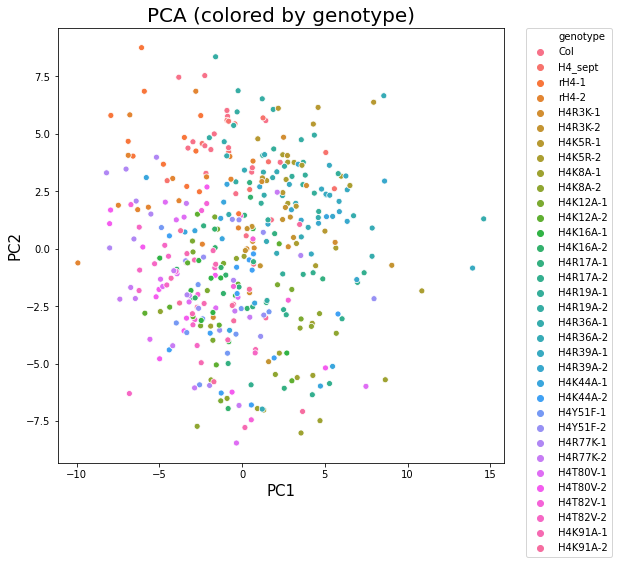

In [12]:
# Visualize 2D projection

# Color by genotype
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34))
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### Perform k-means Clustering

In [13]:
# Run k-means
kmeans_labels = KMeans(n_clusters=5).fit_predict(x)

In [14]:
# Add k-means cluster column to finalDf
finalDf['cluster'] = kmeans_labels

In [15]:
finalDf.head()

,PC1,PC2,PC3,file,genotype,cluster
0,5.985635,3.157928,-0.976183,4-9 12,H4K5R-2,2
1,-2.714058,-7.723927,-1.737267,7-2 7,H4K8A-2,0
2,-4.373081,-2.539305,1.040114,9-7 8,H4K12A-2,1
3,6.269301,3.166052,2.033413,29-3 3,H4R39A-1,2
4,2.981505,1.696205,0.140551,29-5 5,H4R39A-2,4


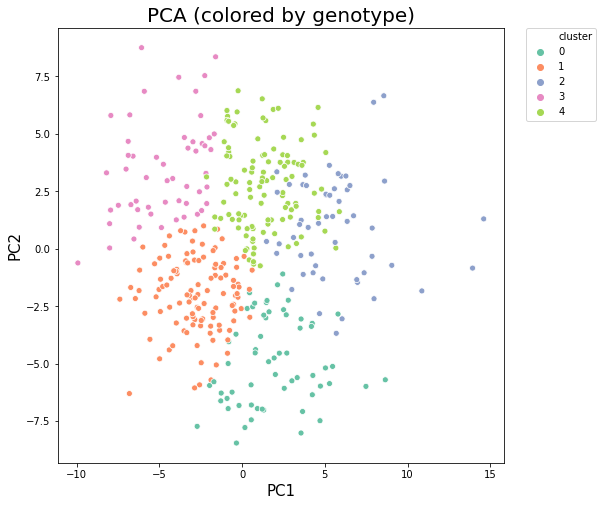

In [16]:
# Visualize 2D projection with k-means labels

# Color by genotype
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by k-means clusters)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='cluster', palette=sns.color_palette("Set2",5))
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Average data by genotype

In [19]:
# Average data by genotype
avg_df = df.groupby('genotype').mean()

### Perform PCA

In [26]:
#Make data frame
#Separate the features
avg_x = avg_df.values
#Separate the labels
avg_y = avg_df.index.values
# Standardize the features
avg_x = StandardScaler().fit_transform(avg_x)

# Run PCA to obtain first 2 principal components
avg_pca = PCA(n_components=3)
avg_principalComponents = avg_pca.fit_transform(avg_x)
avg_principalDf = pd.DataFrame(data = avg_principalComponents, columns = ['PC1', 'PC2', 'PC3'])
avg_principalDf['genotype'] = avg_df.index.values
avg_principalDf.head()

,PC1,PC2,PC3,genotype
0,-2.324562,-5.776688,1.490562,Col
1,-1.212971,1.921778,-0.226062,H4K12A-1
2,-1.901143,2.809115,-0.407934,H4K12A-2
3,-1.640059,2.242065,0.257030,H4K16A-1
4,-2.111304,1.555465,3.312293,H4K16A-2


In [27]:
# Print proportions of explained variance by each PC
avg_ex_var = avg_pca.explained_variance_ratio_

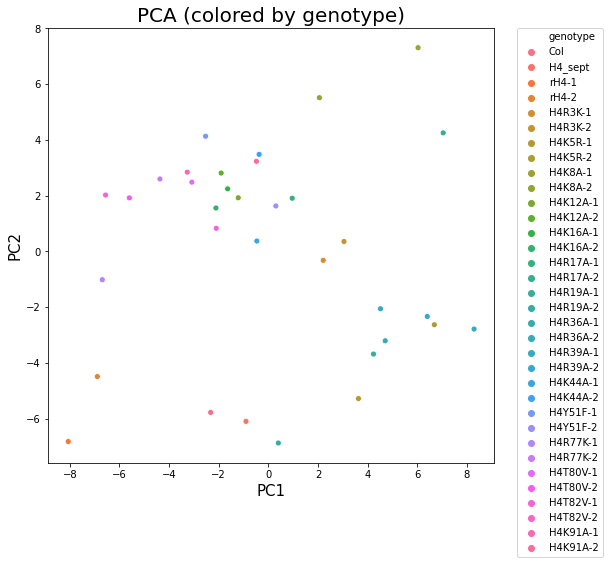

In [28]:
# Visualize 2D projection

# Color by genotype
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(avg_ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(avg_ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=avg_principalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34))
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

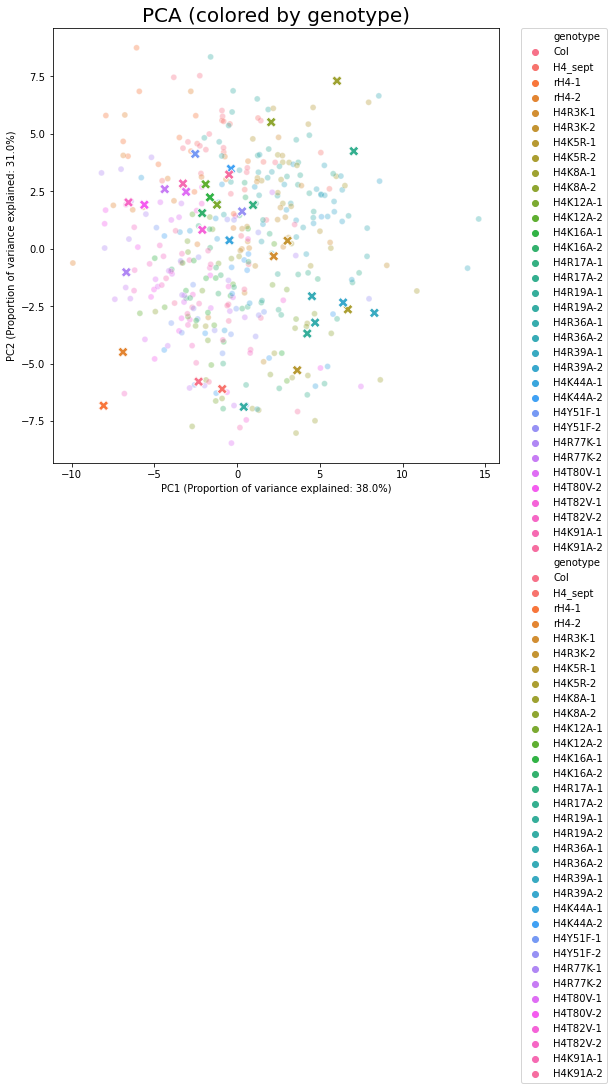

In [63]:
# Visualize averages on top of individual replicates
# Visualize 2D projection

# Color by genotype
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_principalDf, hue='genotype', hue_order=order, 
                palette=sns.color_palette("husl", 34), marker='X', s=100)
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

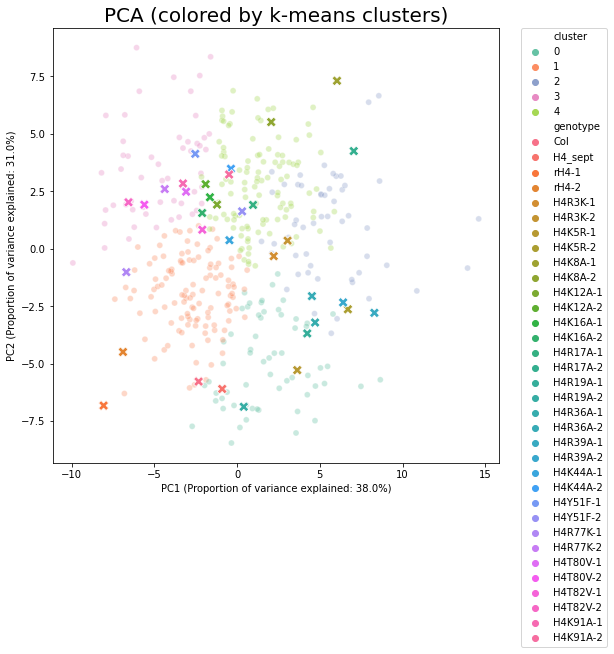

In [62]:
# Visualize averages on top of individual replicates
# Visualize 2D projection with k-means labels

# Color by kmeans labels
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by k-means clusters)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='cluster', palette=sns.color_palette("Set2",5),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_principalDf, hue='genotype', hue_order=order, 
                palette=sns.color_palette("husl", 34), marker='X', s=100)
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### k-means Clustering

In [71]:
# Run k-means
avg_kmeans_labels = KMeans(n_clusters=3).fit_predict(avg_x)

In [72]:
# Add k-means cluster column to finalDf
avg_principalDf['cluster'] = avg_kmeans_labels

In [73]:
avg_principalDf.head()

,PC1,PC2,PC3,genotype,cluster
0,-2.324562,-5.776688,1.490562,Col,2
1,-1.212971,1.921778,-0.226062,H4K12A-1,1
2,-1.901143,2.809115,-0.407934,H4K12A-2,1
3,-1.640059,2.242065,0.257030,H4K16A-1,1
4,-2.111304,1.555465,3.312293,H4K16A-2,1


In [ ]:
avg_principalDf

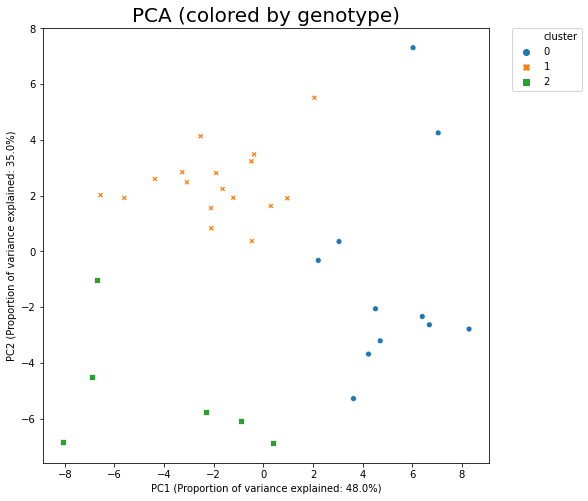

In [78]:
# Visualize 2D projection

# Color by genotype
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(avg_ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(avg_ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=avg_principalDf, hue='cluster',  palette=sns.color_palette("tab10",3), style='cluster')
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

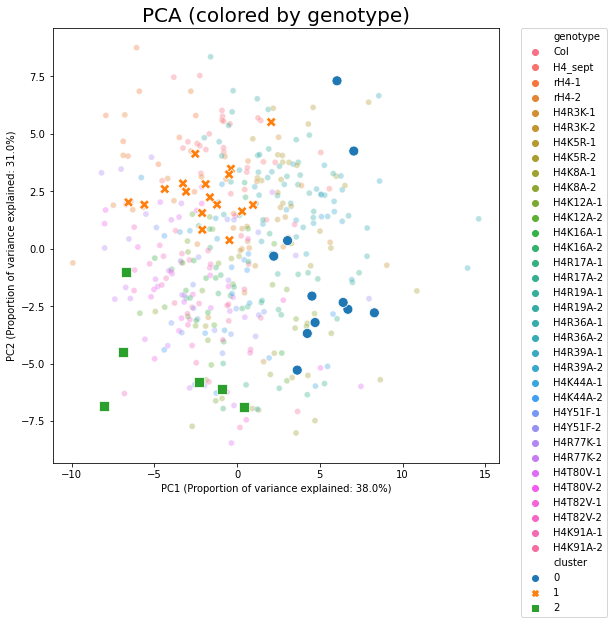

In [79]:
# Visualize averages on top of individual replicates
# Visualize 2D projection

# Color by genotype
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by genotype)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
order = metadata['genotype']
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='genotype', hue_order=order, palette=sns.color_palette("husl", 34),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_principalDf, hue='cluster',  palette=sns.color_palette("tab10",3), style='cluster',s=100)
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

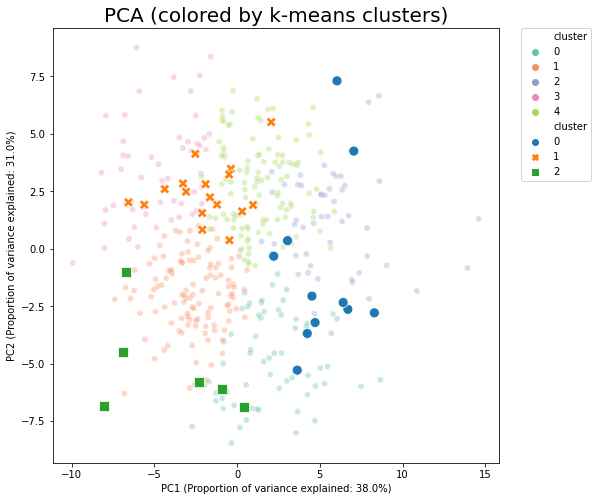

In [80]:
# Visualize averages on top of individual replicates
# Visualize 2D projection with k-means labels

# Color by kmeans labels
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA (colored by k-means clusters)', fontsize = 20)
xlab = "PC1 (Proportion of variance explained: "+str(round(ex_var[0]*100))+"%)"
ylab = "PC2 (Proportion of variance explained: "+str(round(ex_var[1]*100))+"%)"
sns.scatterplot(x="PC1", y="PC2", data=finalDf, hue='cluster', palette=sns.color_palette("Set2",5),alpha=0.35)
sns.scatterplot(x="PC1", y="PC2", data=avg_principalDf, hue='cluster',  palette=sns.color_palette("tab10",3), style='cluster',s=100)
ax.set(xlabel=xlab, ylabel = ylab)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)